In [1]:
from datetime import datetime
import itertools
import json

import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import torch
from torch.utils.data import DataLoader

from database import data_utils, data_loader, shape_utils
from models import basic_ff
import run_models

importlib.reload(data_utils)
importlib.reload(basic_ff)
importlib.reload(data_loader)
importlib.reload(shape_utils)

RUN_FOLDER = "../results/3_mo_cross_val/"

In [2]:
train_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "train_traces.pkl")
test_traces = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "test_traces.pkl")
with open(RUN_FOLDER + "kcm/deeptte_formatted/" + "config.json") as f:
    config = json.load(f)
gtfs_data = data_utils.merge_gtfs_files("." + config['gtfs_folder'])

In [3]:
train_traces.head()

,trip_id,file,locationtime,lat,lon,vehicle_id,speed_m_s,dist_calc_m,time_calc_s,dist_calc_km,...,timeID,timeID_s,shingle_id,stop_dist_km,stop_arrival_s,stop_lon,stop_lat,trip_start_timeID_s,scheduled_time_s,vehicle_id_recode
0,478065569,2022_01_02.pkl,1641128355,47.401463,-122.297646,6105.0,1.592291,46.176435,29.0,0.046176,...,299,17955,0,0.011051,18462,-122.295349,47.435078,17955,507,1100
1,478065569,2022_01_02.pkl,1641128401,47.408894,-122.298058,6105.0,9.649471,443.875669,46.0,0.443876,...,300,18001,0,0.011051,18462,-122.295349,47.435078,17955,507,1100
2,478065569,2022_01_02.pkl,1641128454,47.414848,-122.297264,6105.0,6.879754,364.626941,53.0,0.364627,...,300,18054,0,0.011051,18462,-122.295349,47.435078,17955,507,1100
3,478065569,2022_01_02.pkl,1641128472,47.414902,-122.297256,6105.0,0.182475,3.284542,18.0,0.003285,...,301,18072,0,0.011051,18462,-122.295349,47.435078,17955,507,1100
4,478065569,2022_01_02.pkl,1641128560,47.423382,-122.296181,6105.0,21.575930,517.822327,24.0,0.517822,...,302,18160,0,0.011051,18462,-122.295349,47.435078,17955,507,1100


In [4]:
gtfs_data.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,peak_flag,fare_id,...,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,arrival_s
0,100129,104497,347458169,Bellevue Via I-405,LOCAL,1,6200507,20237002,0,101,...,Woodinville Park And Ride,NaN,47.756782,-122.151398,19,NaN,0,NaN,America/Los_Angeles,24720
226,100129,104497,347458169,Bellevue Via I-405,LOCAL,1,6200507,20237002,0,101,...,138th Pl NE & NE 178th Pl,NaN,47.756855,-122.155403,19,NaN,0,NaN,America/Los_Angeles,24768
298,100129,104497,347458169,Bellevue Via I-405,LOCAL,1,6200507,20237002,0,101,...,138th Pl NE & NE 175th St,NaN,47.754986,-122.155319,19,NaN,0,NaN,America/Los_Angeles,24793
370,100129,104497,347458169,Bellevue Via I-405,LOCAL,1,6200507,20237002,0,101,...,NE 175th St & 135th Ave NE,NaN,47.754551,-122.159569,19,NaN,0,NaN,America/Los_Angeles,24839
384,100129,104497,347458169,Bellevue Via I-405,LOCAL,1,6200507,20237002,0,101,...,131st Ave NE & NE 175th St,NaN,47.754749,-122.165237,19,NaN,0,NaN,America/Los_Angeles,24894


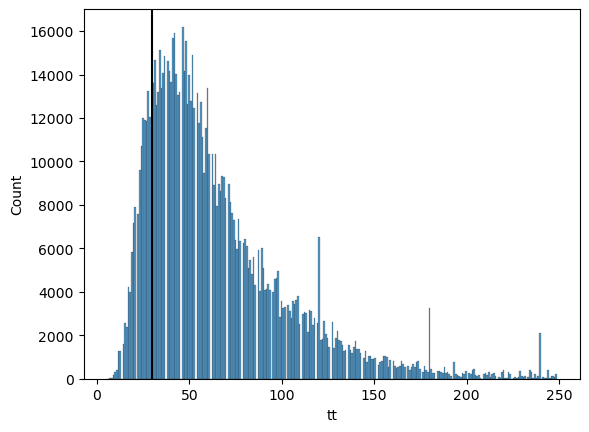

In [5]:
# Histogram of bus travel times in schedule
gtfs_data['arrival_s_prev'] = gtfs_data.groupby('trip_id').shift()[['arrival_s']]
gtfs_data_times = gtfs_data[['arrival_s','arrival_s_prev']].dropna()
gtfs_data_times['tt'] = gtfs_data_times['arrival_s'] - gtfs_data_times['arrival_s_prev']
# Time between bus stops
sns.histplot(gtfs_data_times.loc[gtfs_data_times['tt']<250, 'tt'])
plt.axvline(30, 0.0, 20000, color="black")

<AxesSubplot: xlabel='dist_calc_m', ylabel='Count'>

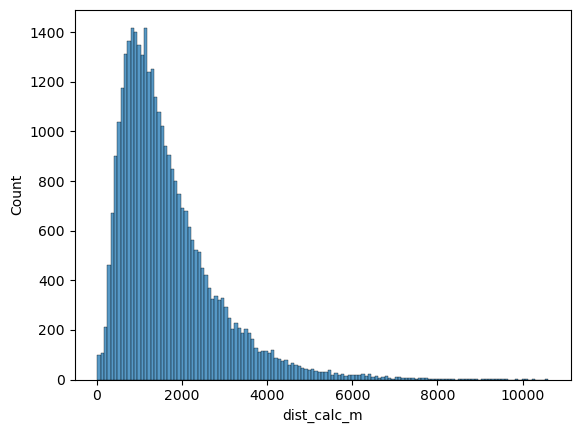

In [6]:
# Shingle distance
sns.histplot(train_traces.groupby('shingle_id').sum(numeric_only=True)['dist_calc_m'])

<AxesSubplot: xlabel='time_cumulative_s', ylabel='Count'>

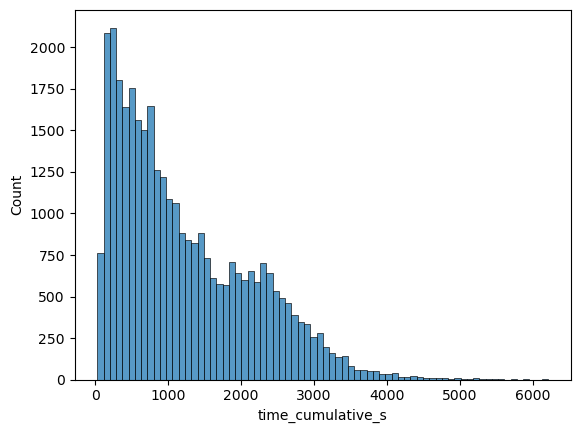

In [7]:
# Shingle travel time
sns.histplot(train_traces.groupby('shingle_id').last()['time_cumulative_s'])

<AxesSubplot: xlabel='lat', ylabel='Count'>

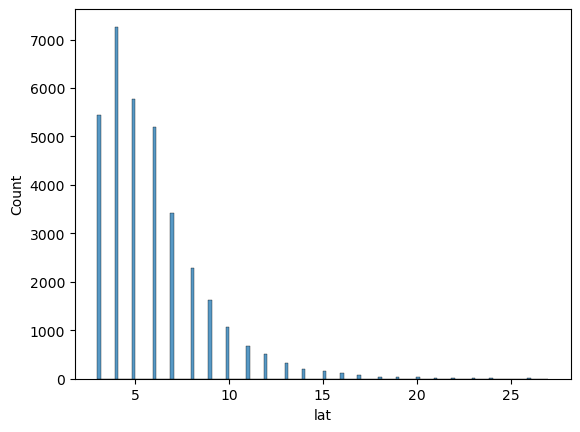

In [8]:
# Points per trajectory
sns.histplot(train_traces.groupby(['shingle_id']).count()['lat'])

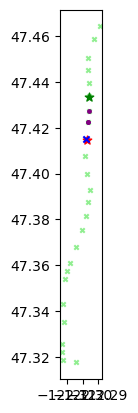

In [33]:
# Look at a single trip
shingle_num = 8
plot_data = train_traces[train_traces['shingle_id']==shingle_num]
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], gtfs_data)
shape_utils.plot_gtfsrt_trip(axes, plot_data)